# Custom Factors

Let's try to create a custom factor that finds the stocks whose price dropped the most within a certain time window. Let's create a sample dataset to help us building this factor.

In [1]:
from quantopian.pipeline.filters import StaticAssets
from quantopian.pipeline.data import USEquityPricing
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.factors import CustomFactor
import numpy as np
start_date = '2019-08-01'
end_date = '2019-10-31' 
tickers = ['FB']

In [2]:
def universe():
    return StaticAssets(symbols(tickers))

def make_pipeline():        
    
    return Pipeline(
        columns={
            'price': USEquityPricing.close.latest
        },
        screen=universe()
    )


p_pipe = make_pipeline()
p_mdf = run_pipeline(p_pipe, start_date, end_date)

Max and today price difference: -3.12%


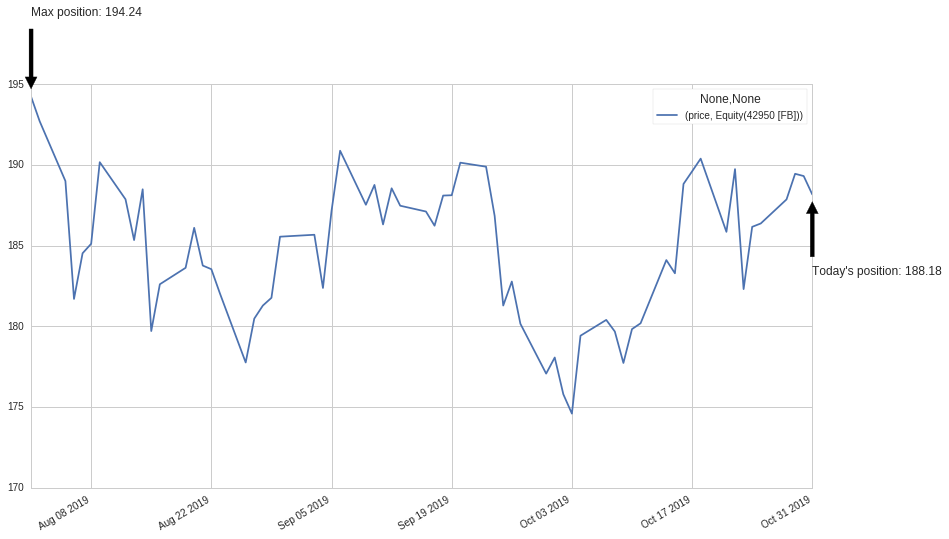

In [3]:
ax = p_mdf.unstack().plot()

ymax = np.amax(p_mdf['price'], axis=0)
xmax = p_mdf[p_mdf['price'] == ymax].index.get_level_values(0)
ax.annotate('Max position: {}'.format(ymax), xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.1),
            )

xtoday = p_mdf.index.get_level_values(0)[-1]
ytoday = p_mdf.loc[(xtoday)]['price'].values[0]
ax.annotate("Today's position: {}".format(ytoday), xy=(xtoday, ytoday), xytext=(xtoday, ytoday-5),
            arrowprops=dict(facecolor='black', shrink=0.1),
            )
print("Max and today price difference: {}%".format(round((ytoday - ymax)/ymax*100, 2)))

There are two important points to note here:

1. The function to find maximum price was `np.amax(p_mdf['price'], axis=0)`
2. The formula to find price difference was `round((ytoday - ymax)/ymax*100, 2)`. In numpy, an equivalent function is [np.around()](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.around.html#numpy.around).

We will apply both points above in our factor:

In [4]:
class PriceDiff(CustomFactor):
    """ Find the maximum price within the past window length,
    then find how far it dropped to the current price (in %).
    """
    inputs=[USEquityPricing.close]
    def compute(self, today, assets, out, p):
        high = np.amax(p, axis=0)
        out[:] = np.around((p[-1] - high) / high*100, decimals=2)

When correct, we should get a value of `-3.12`as our factor's last output. To properly test this, we need to have a window length that is similar to our test dataset, which is the number of business days between `start_date` and `end_date`.

In [5]:
window = np.busday_count(start_date, end_date)
print(window)

65


In [6]:
def universe():
    return StaticAssets(symbols(tickers))

def make_pipeline():
    
    u = universe()
    
    # Use `mask` argument so we don't end up calculating price difference for all 8000+ assets. 
    pd = PriceDiff(window_length=window, mask=u)
    
    return Pipeline(
        columns={
            'price_diff': pd
        },
        screen=u
    )


pd_pipe = make_pipeline()
pd_mdf = run_pipeline(pd_pipe, start_date, end_date)
pd_mdf.tail(1)

,,price_diff
2019-10-31 00:00:00+00:00,Equity(42950 [FB]),-3.12


In [7]:
pd_mdf.shape

(65, 1)

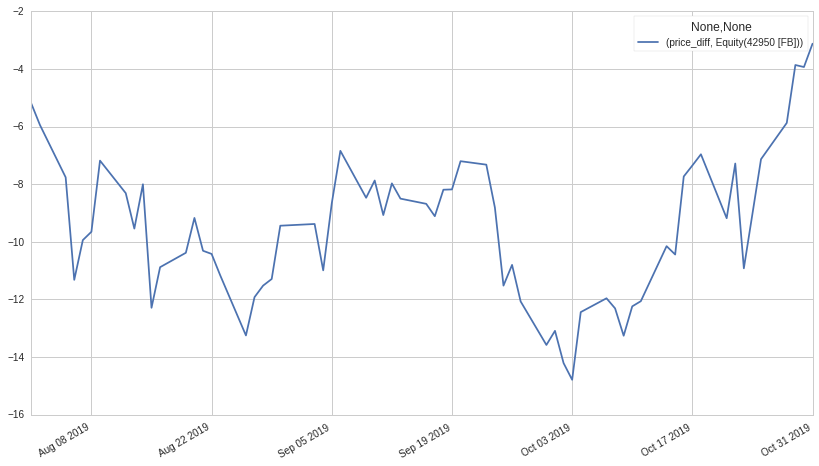

In [8]:
ax = pd_mdf.unstack().plot()